In [1]:
import sys; sys.path.append('../..')
from heatwave import ERA, Country, utils

import netCDF4

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.cluster import AgglomerativeClustering
from scipy.ndimage import *
from scipy.interpolate import griddata
from scipy.signal import detrend, windows

from eofs.standard import Eof

import calendar
import os

# Data Sources

In [2]:
ROOT = '/Volumes/Samsung_T5/Thesis'

PLOT = False
TIME = [0] if PLOT else None

SOURCE = 'ERA'
OUTPUT = os.path.join(ROOT, SOURCE, 'timeseries')
OUTPUT_IMAGE = os.path.join(ROOT, SOURCE, 'images')

if not os.path.exists(OUTPUT): os.makedirs(OUTPUT)
if not os.path.exists(OUTPUT_IMAGE): os.makedirs(OUTPUT_IMAGE)


# ERA-Interim
if SOURCE == 'ERA':
    ERA_US_075 = slice(54, 88), slice(313, 392)
    ERA_NORTH = slice(4, 41), None
    LSM = ERA(os.path.join(ROOT, 'ERA/landseamask_0.75deg.nc'), 'lsm', index=[TIME, *ERA_US_075])
    T2M = ERA(os.path.join(ROOT, 'ERA/t2m_1979-2017_1_12_daily_0.75deg.nc'), 't2m', index=[TIME, *ERA_US_075])
    SM1 = ERA(os.path.join(ROOT, 'ERA/sm1_1979-2017_1_12_daily_0.75deg.nc'), 'swvl1', index=[TIME, *ERA_US_075])
    SM2 = ERA(os.path.join(ROOT, 'ERA/sm2_1979-2017_1_12_daily_0.75deg.nc'), 'swvl2', index=[TIME, *ERA_US_075])
    SM3 = ERA(os.path.join(ROOT, 'ERA/sm3_1979-2017_2jan_31okt_dt-1days_0.75deg.nc'), 'swvl3', index=[TIME, *ERA_US_075])
    SST = ERA(os.path.join(ROOT, 'ERA/sst_1979-2017_1_12_daily_2.5deg.nc'), 'sst', index=[TIME, *ERA_NORTH])
    SLP = ERA(os.path.join(ROOT, 'ERA/SLP_1979-2017_1jan_31dec_dt-1days_2.5deg.nc'), 'msl', index=[TIME, *ERA_NORTH])
    
    USM = (utils.era_country_mask(T2M.path) == Country.US)[ERA_US_075]
    

# ERA-5
if SOURCE == 'ERA5':
    ERA5_T2M_US_025 = slice(42, 141), slice(21, 254)
    ERA5_SML_US_025 = slice(2, 101), slice(21, 254)
    ERA5_LSM_US = slice(162, 261), slice(941, 1174)
    LSM = ERA(os.path.join(ROOT, 'ERA5/landseamask_0.25deg.nc'), 'lsm', index=[TIME, *ERA5_LSM_US])
    T2M = ERA(os.path.join(ROOT, 'ERA5/t2mmax_US_1979-2018_1jan_31dec_daily_0.25deg.nc'), 't2m', index=[TIME, *ERA5_T2M_US_025])
    SM1 = ERA(os.path.join(ROOT, 'ERA5/sm_1_1979-2018_1jan_31dec_daily_0.25deg.nc'), 'swvl1', index=[TIME, *ERA5_SML_US_025])
    SM2 = ERA(os.path.join(ROOT, 'ERA5/sm_2_1979-2018_1jan_31dec_daily_0.25deg.nc'), 'swvl2', index=[TIME, *ERA5_SML_US_025])
    SM3 = ERA(os.path.join(ROOT, 'ERA5/sm_3_1979-2018_1jan_31dec_daily_0.25deg.nc'), 'swvl3', index=[TIME, *ERA5_SML_US_025])
    SST = ERA(os.path.join(ROOT, 'ERA5/sst_1979-2018_1jan_31dec_daily_2.5deg.nc'), 'sst', index=[TIME, slice(4, -4)])
    SLP = ERA(os.path.join(ROOT, 'ERA5/SLP_1979-2018_1jan_31dec_daily_2.5deg.nc'), 'msl', index=[TIME, slice(4, 40)])
    
    USM = (utils.era_country_mask(T2M.path) == Country.US)[ERA5_T2M_US_025]

# EC-Earth
if SOURCE == 'EC-Earth':
    ECE_US_25 = None, slice(2, -1)
    ECE_US_25_FULL = slice(35, 59), slice(209, 262)
    ECE_KWARGS = dict(longitude_key='lon', latitude_key='lat')
    LSM = ERA(os.path.join(ROOT, 'EC-Earth/EC_earth2.3_LSM_T159.nc'), 'LSM', index=[TIME, *ECE_US_25_FULL], **ECE_KWARGS)
    T2M = ERA(os.path.join(ROOT, 'EC-Earth/160/tas_d_ECEarth_PD_1start_10ens_lastyr.nc'), 'tas', index=[TIME, *ECE_US_25], **ECE_KWARGS)
    SM1 = ERA(os.path.join(ROOT, 'EC-Earth/160/mrlsl1_d_ECEarth_PD_1start_10ens_lastyr.nc'), 'mrlsl1', index=[TIME, *ECE_US_25], **ECE_KWARGS)
    SM2 = ERA(os.path.join(ROOT, 'EC-Earth/160/mrlsl2_d_ECEarth_PD_1start_10ens_lastyr.nc'), 'mrlsl2', index=[TIME, *ECE_US_25], **ECE_KWARGS)
    SM3 = ERA(os.path.join(ROOT, 'EC-Earth/160/mrlsl3_d_ECEarth_PD_1start_10ens_lastyr.nc'), 'mrlsl3', index=[TIME, *ECE_US_25], **ECE_KWARGS)
    SST = ERA(os.path.join(ROOT, 'EC-Earth/160/tos_d_ECEarth_PD_1start_10ens_lastyr.nc'), 'tos', index=[TIME], **ECE_KWARGS)
    SLP = ERA(os.path.join(ROOT, 'EC-Earth/160/psl_d_ECEarth_PD_1start_10ens_lastyr.nc'), 'psl', index=[TIME], **ECE_KWARGS)
    
    USM = (utils.era_country_mask(T2M.path) == Country.US)[..., ECE_US_25[-1]]

if PLOT:
    utils.plot_earth("US")
    plt.pcolormesh(LSM.longitude, LSM.latitude, LSM.data[0])
    plt.colorbar()
    plt.title("Land-Sea-Mask")
    plt.show()
    
    utils.plot_earth("US")
    plt.pcolormesh(T2M.longitude, T2M.latitude, USM.astype(np.float32))
    plt.colorbar()
    plt.title("US Mask")
    plt.show()
    
    utils.plot_earth("US")
    plt.pcolormesh(T2M.longitude, T2M.latitude, T2M.data[0])
    plt.title("Temperature at 2 Metres")
    plt.colorbar()
    plt.show()

    utils.plot_earth("US")
    plt.pcolormesh(SM1.longitude, SM1.latitude, SM1.data[0])
    plt.title("Soil Moisture (Level 1)")
    plt.colorbar()
    plt.show()

    utils.plot_earth("US")
    plt.pcolormesh(SM2.longitude, SM2.latitude, SM2.data[0])
    plt.title("Soil Moisture (Level 2)")
    plt.colorbar()
    plt.show()

    utils.plot_earth("US")
    plt.pcolormesh(SM3.longitude, SM3.latitude, SM3.data[0])
    plt.title("Soil Moisture (Level 3)")
    plt.colorbar()
    plt.show()

    utils.plot_earth()
    plt.pcolormesh(SST.longitude, SST.latitude, SST.data[0])
    plt.title("Sea Surface Temperature")
    plt.colorbar()
    plt.show()

    utils.plot_earth()
    plt.pcolormesh(SLP.longitude, SLP.latitude, SLP.data[0])
    plt.title("Surface Level Pressure")
    plt.colorbar()
    plt.show()

# Helper Functions

In [3]:
def anomaly(era: ERA, window: int = 31):
    return anomaly_df(pd.DataFrame(era.data.reshape(len(era.time), -1), index=era.time.index), window).values.reshape(era.shape)
            
def anomaly_df(df: pd.DataFrame, window: int = 31):
    climatology = df.rolling(window, center=True, win_type='gaussian').mean(std=window/2).groupby([df.index.month, df.index.day]).apply(lambda x: x.mean())
    return df.groupby([df.index.month, df.index.day]).apply(lambda x: x - climatology.loc[x.index.month[0], x.index.day[0]])

In [4]:
def summer_indices(df: pd.DataFrame):
    summer_series = []
    for year in np.unique(df.index.year):        
        if calendar.isleap(year) and not SOURCE == 'EC-Earth':
            summer_series.append(df.loc[f"23-06-{year}":f"21-08-{year}"])
        else:
            summer_series.append(df.loc[f"24-06-{year}":f"22-08-{year}"])    
    return pd.concat(summer_series).values.ravel()

In [5]:
def to_slice(mask):
    indices = np.nonzero(mask)[0]
    return slice(indices[0], indices[-1])

# Create United States Mask

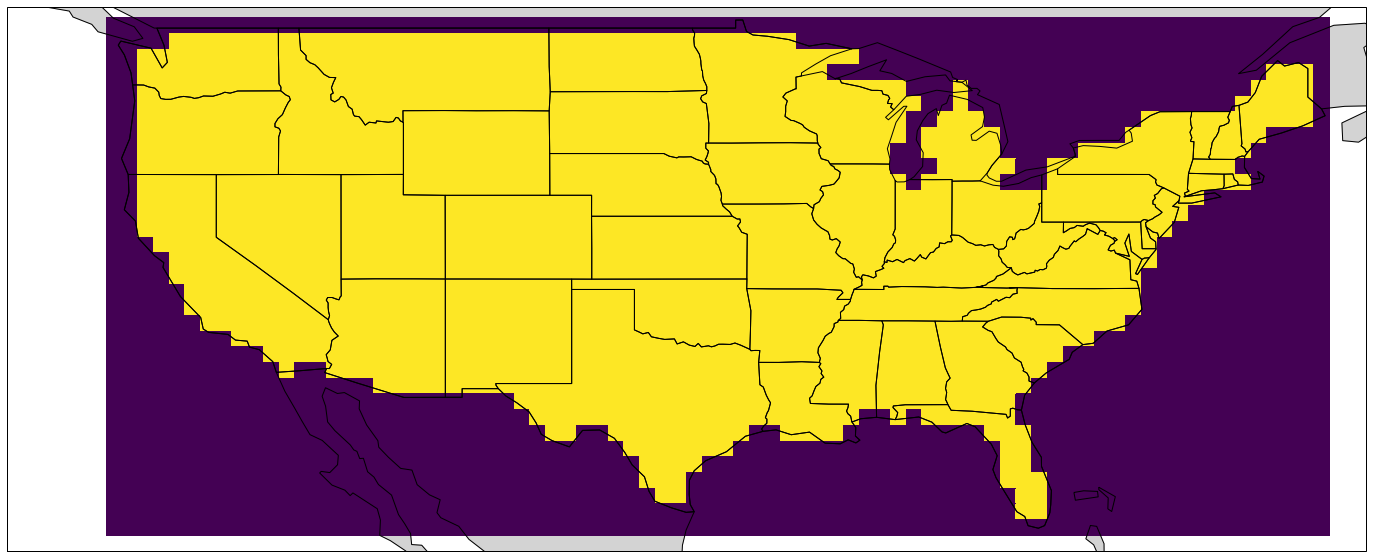

In [6]:
US_MASK = binary_closing(USM) * (LSM.data[0] > 0.5)

utils.plot_earth("US")
plt.pcolormesh(T2M.longitude, T2M.latitude, US_MASK.astype(np.float32))
plt.show()

# Cluster Eastern United States

/Users/bram/miniconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4315: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))
/Users/bram/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in greater


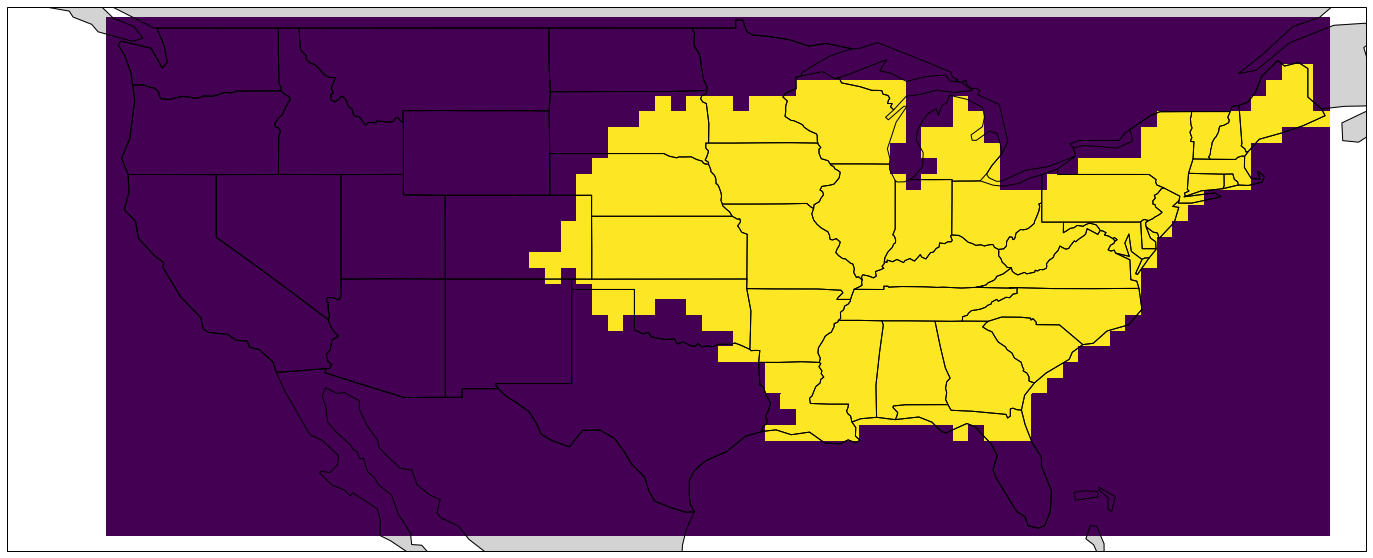

In [7]:
dataset_path = os.path.join(ROOT, 'east_us_mask.nc')


summer = summer_indices(T2M.time)
t2m = (T2M.data if SOURCE == 'ERA5' else anomaly(T2M))[summer][..., US_MASK]
t95_bool = t2m > np.quantile(t2m, 0.95, 0)

if SOURCE == 'ERA5':
    
    N = 4
    cluster = AgglomerativeClustering(N, affinity='jaccard', linkage='average')
    cluster.fit(t95_bool.T)

    # Create 2D Label Array
    labels = np.empty(T2M.data.shape[1:])
    labels.fill(np.nan)
    labels[US_MASK] = cluster.labels_

    # Identify East US Label,
    east_label = np.argmax([np.max(np.nonzero(labels == i)[1]) for i in range(N)])
    east_mask = labels == east_label

    projection = utils.plot_earth("US")
    plt.pcolormesh(T2M.longitude, T2M.latitude, labels)
    plt.savefig(os.path.join(OUTPUT_IMAGE, 'cluster.png'))
    plt.show()
    
    if os.path.exists(dataset_path): os.remove(dataset_path)
    
    dataset = netCDF4.Dataset(dataset_path, 'w', format='NETCDF4_CLASSIC')
    
    time = dataset.createDimension('time', 1)
    lat = dataset.createDimension('lat', T2M.shape[1])
    lon = dataset.createDimension('lon', T2M.shape[2])

    times = dataset.createVariable('time', np.float32, ('time',))
    latitudes = dataset.createVariable('latitude', np.float32, ('lat',))
    longitudes = dataset.createVariable('longitude', np.float32, ('lon',))
    var = dataset.createVariable('mask', np.float32, ('time','lat','lon'))

    latitudes[:] = T2M.latitude
    longitudes[:] = T2M.longitude

    times.units = "days since 2000-01-01 12:00:00"
    times.calendar = 'noleap'
    
    times[0] = 0
    var[0] = east_mask.astype(np.float32)
    
    dataset.close()
else:
    mask = ERA(dataset_path, 'mask')
    
    mask_grid = [360, 0] + utils.era_coordinate_grid(mask.path)
    target_grid = utils.era_coordinate_grid(T2M.path)
    
    result = griddata(mask_grid.reshape(-1, 2), mask.data.ravel(), target_grid.reshape(-1, 2), method='linear')
    result = result.reshape(target_grid.shape[:-1])[T2M._index[1], T2M._index[2]] * (LSM.data[0] > 0.5) > 0.5
    
    east_mask = result
    
projection = utils.plot_earth("US")
plt.pcolormesh(T2M.longitude, T2M.latitude, east_mask.astype(np.float32))
plt.show()

# Calculate T95 Heatwave Timeseries

In [8]:
T95 = pd.DataFrame(t2m[:, east_mask[US_MASK]], index=T2M.time.iloc[summer].index).quantile(0.95, 1)
T95 = (T95 - T95.mean()) / T95.std()

T95.to_csv(os.path.join(OUTPUT, 'T95.csv'), header=False)

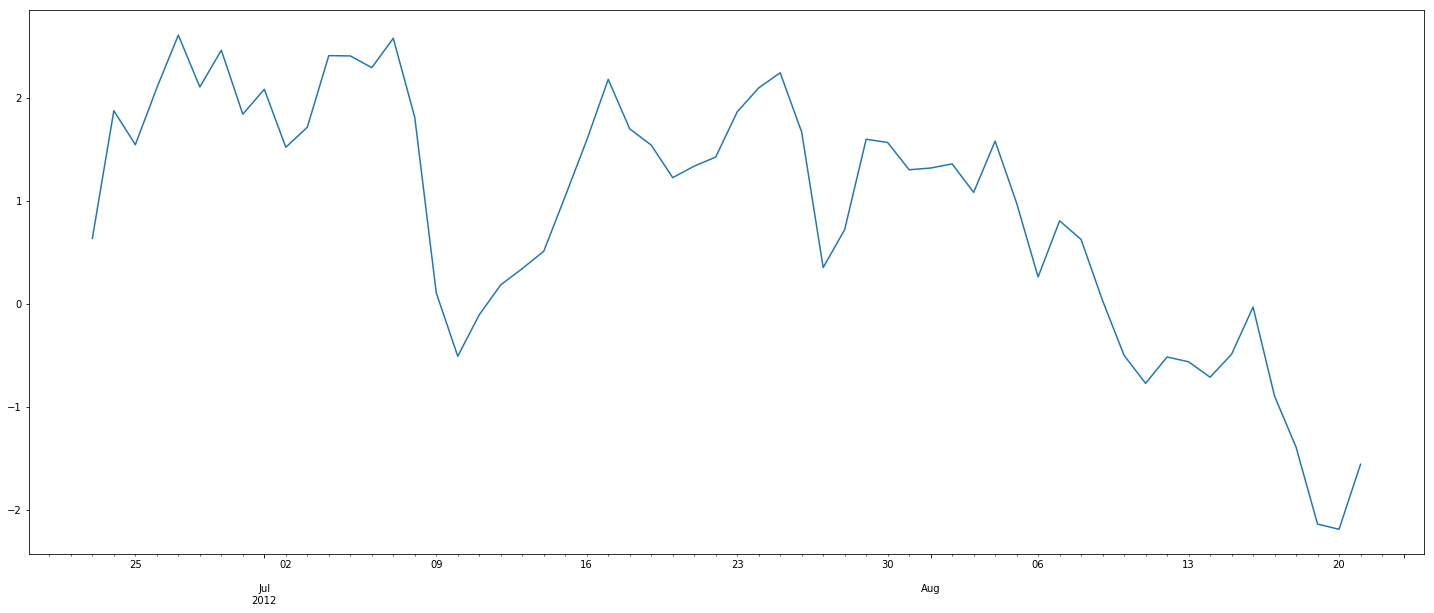

In [9]:
T95["2012"].plot()
plt.show()

# Calculate Soil Moisture Timeseries

/Users/bram/miniconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4315: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))
/Users/bram/miniconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4315: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))


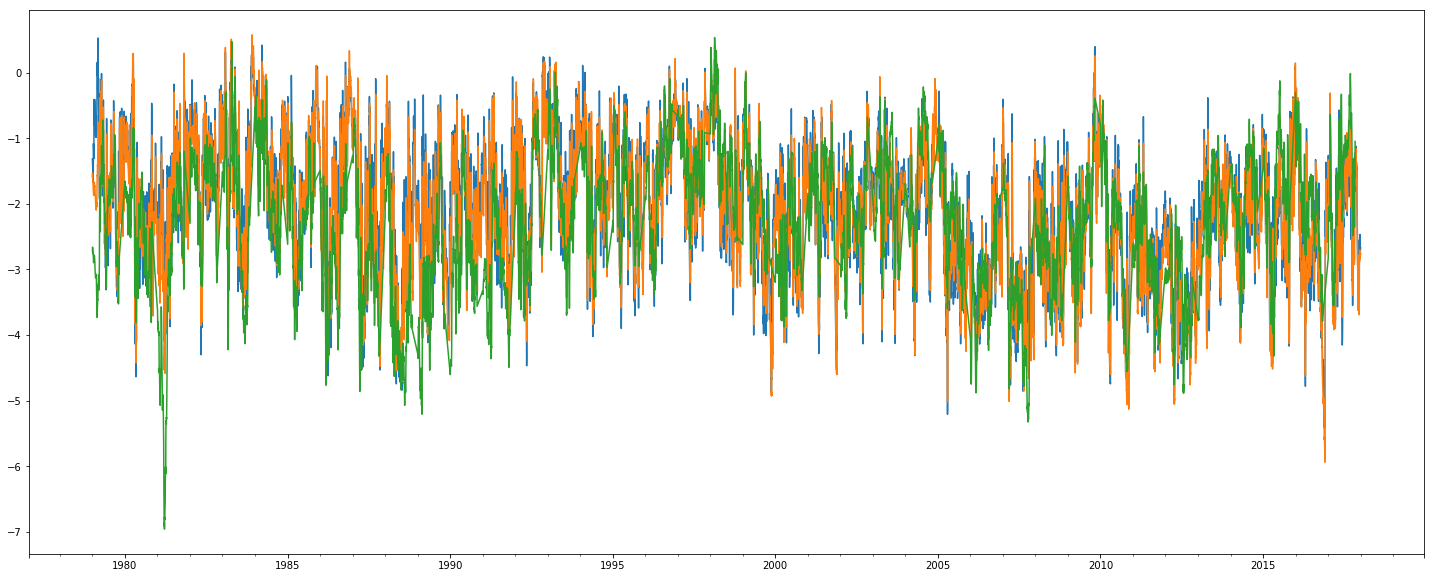

In [10]:
for i, SM in enumerate([SM1, SM2, SM3], 1):
    sm = pd.DataFrame(np.nan_to_num(SM.data[:, east_mask]), index=SM.time.index)
    sm = sm if SOURCE == 'ERA5' else anomaly_df(sm)
    sm = sm.quantile(0.05, 1)
    sm /= sm.std()
    sm.to_csv(os.path.join(OUTPUT, f'SM{i}.csv'), header=False)
    sm.plot()
plt.show()

# NOAA Oceanic Niño Index (ONI)

/Users/bram/miniconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4315: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))


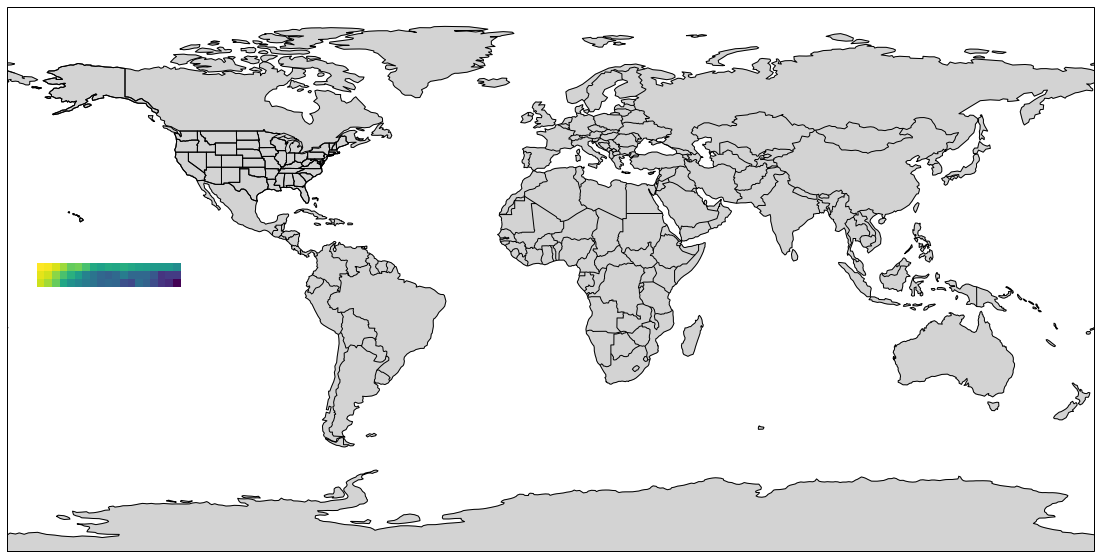

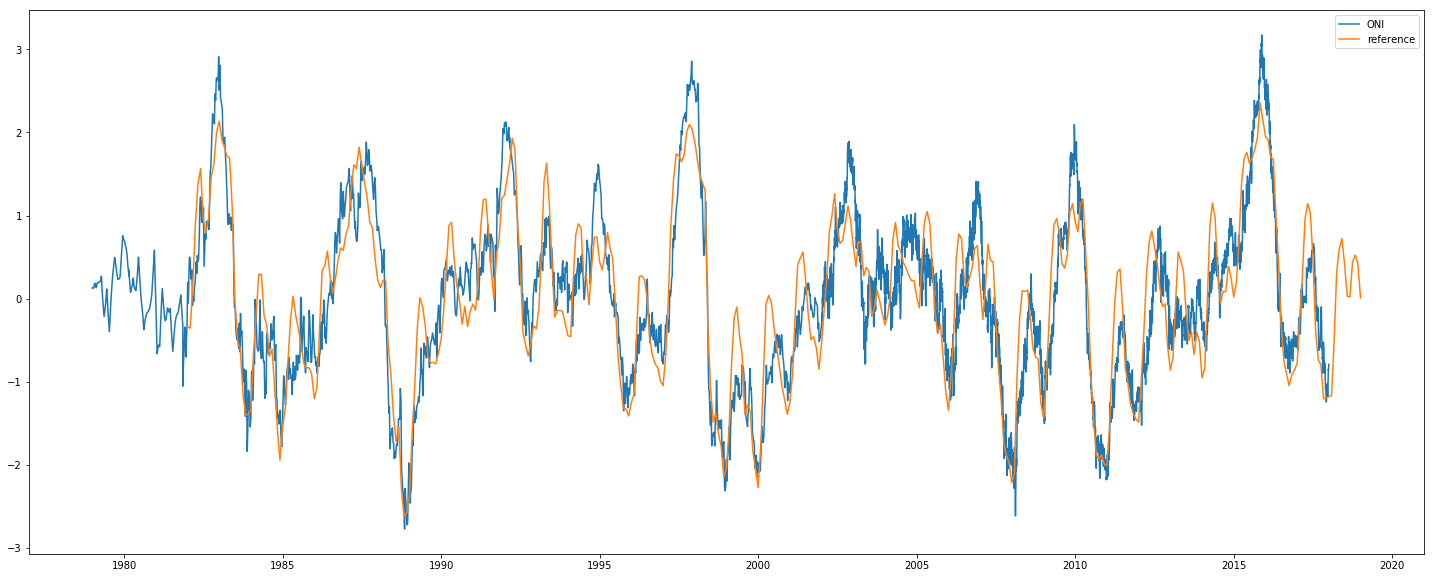

In [11]:
ONI_LATITUDE_MASK = (SST.latitude >= -5) * (SST.latitude <= 5)
ONI_LONGITUDE_MASK = (SST.longitude >= 190) * (SST.longitude <= 240)

ONI = SST.reindex([None, to_slice(ONI_LATITUDE_MASK), to_slice(ONI_LONGITUDE_MASK)])

oni = ONI.data if SOURCE == 'ERA5' else anomaly(ONI)
oni = pd.DataFrame(oni.mean(axis=(1,2)).reshape(len(ONI.time), -1), index=ONI.time.index)
oni /= oni.std()
oni.to_csv(os.path.join(OUTPUT, 'ONI.csv'), header=False)

# Plot Results
utils.plot_earth()
plt.pcolormesh(ONI.longitude, ONI.latitude, ONI.data[0])
plt.show()

plt.plot(oni, label='ONI')

if SOURCE != 'EC-Earth':
    oni_reference = pd.read_csv(os.path.join(ROOT, "CPC", "ENSO.txt"), sep='\s+')
    oni_reference["date"] = pd.to_datetime({"year": oni_reference.YR, "month": oni_reference.MON, "day": 1})
    oni_reference = oni_reference.set_index(oni_reference["date"])
    oni_reference = oni_reference[["NINO3.4"]]
    oni_reference = (oni_reference - oni_reference.mean()) / oni_reference.std()
    plt.plot(oni_reference, label='reference')
    
plt.legend()
plt.show()

# Pacific North American Index (PNA) 2

In [12]:
def get_data(era, lat, lon):
    return np.nan_to_num(era.data[:, lat, :][:, :, lon])

R1 = (SLP.latitude >= 15) * (SLP.latitude <= 25), \
     (SLP.longitude >= 180) * (SLP.longitude <= 220)

R2 = (SLP.latitude >= 40) * (SLP.latitude <= 50), \
     (SLP.longitude >= 180) * (SLP.longitude <= 220)

R3 = (SLP.latitude >= 45) * (SLP.latitude <= 60), \
     (SLP.longitude >= 235) * (SLP.longitude <= 255)
    
R4 = (SLP.latitude >= 25) * (SLP.latitude <= 35), \
     (SLP.longitude >= 270) * (SLP.longitude <= 290)


r = []
for R in [R1, R2, R3, R4]:
    slp = pd.DataFrame(get_data(SLP, *R).reshape(len(SLP.time), -1), index=SLP.time.index)
    slp = slp if SOURCE == 'ERA5' else anomaly_df(slp)
    r.append(slp.mean(1))

pna = r[0] - r[1] + r[2] - r[3]

pna /= pna.std()
pna.to_csv(os.path.join(OUTPUT, 'PNA.csv'), header=False)

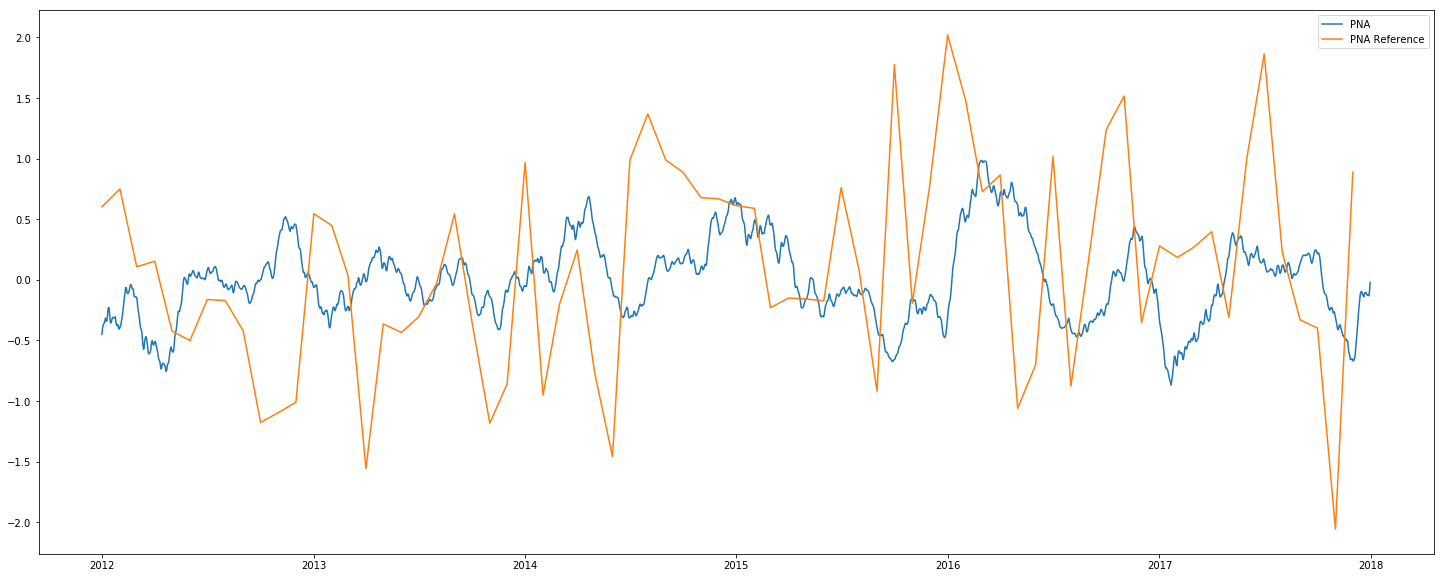

In [14]:
INDEX = slice("2012", "2017")
plt.plot(pna.rolling(60).mean()[INDEX], label="PNA")

if SOURCE != 'EC-Earth':
    pna_reference = pd.read_csv(os.path.join(ROOT, "CPC", "PNA.txt"), sep='\s+', header=None, names=["year", "month", "pna"])
    pna_reference["date"] = pd.to_datetime({"year": pna_reference.year, "month": pna_reference.month, "day": 1})
    pna_reference = pna_reference.set_index(pna_reference["date"])
    pna_reference = pna_reference[["pna"]]
    plt.plot(pna_reference[INDEX], label="PNA Reference")
    
plt.legend()
plt.show()

Mmmke ????

# Pacific Decedal Oscilation

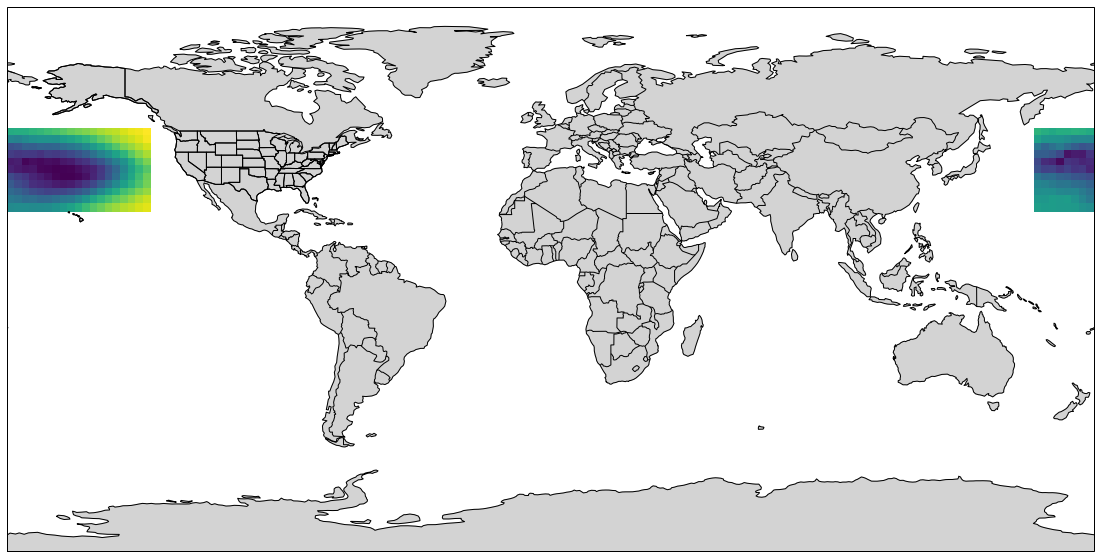

In [13]:
PDO_LATITUDE_MASK = (SST.latitude >= 20) * (SST.latitude <= 50)
PDO_LONGITUDE_MASK = (SST.longitude >= 160) * (SST.longitude <= 230)

PDO = SST.reindex([None, to_slice(PDO_LATITUDE_MASK), to_slice(PDO_LONGITUDE_MASK)])
PDO_anomaly = PDO.data if SOURCE == 'ERA5' else anomaly(PDO)

eof = Eof(PDO_anomaly).eofs()[0]
eof *= -np.sign(np.mean(eof))

pdo = pd.DataFrame((PDO_anomaly * eof).mean(axis=(1,2)), index=SST.time.index)
pdo /= pdo.std()
pdo.to_csv(os.path.join(OUTPUT, "PDO.csv"), header=False)

utils.plot_earth()
plt.pcolormesh(PDO.longitude, PDO.latitude, eof)
plt.show()

# Composites

In [16]:
def composite(anomaly, lag):
    composite = np.nanmean(anomaly[summer_indices(SST.time) - LAG] * T95_binary[:, None, None], 0)
    
    # Normalize Composite
    valid = [~np.isnan(composite)]
    composite[valid] = (composite[valid] - composite[valid].mean()) / composite[valid].std()
    
    return composite

def regions(composite, threshold):
    composite = binary_opening(binary_erosion(np.abs(composite) > threshold))
    regions, _ = measurements.label(composite)
    return regions

def save_regions(regions, anomaly, tag, index):
    
    # Remove Previous Data for this Tag
    for path in os.listdir(OUTPUT):
        if path.startswith(tag):
            os.remove(os.path.join(OUTPUT, path))

    # Generate Regions
    for region in np.unique(regions)[1:]:
        indices = np.argwhere([regions == region])

        timeseries = np.mean(anomaly[:, indices[:, 1], indices[:, 2]], 1)
        timeseries = pd.DataFrame(timeseries, index=index)
        
        timeseries = (timeseries - timeseries.mean()) / timeseries.std()

        timeseries.interpolate().to_csv(os.path.join(OUTPUT, f'{tag}_{region}.csv'), header=False)

def plot_regions(regions, era):
    regions_plot = regions.astype(np.float32)
    regions_plot[regions == 0] = np.nan

    utils.plot_earth()
    plt.pcolormesh(era.longitude, era.latitude, regions_plot, cmap="Set3")
    plt.colorbar()
    plt.show()

In [17]:
LAG = 50

T95_binary = T95.values.ravel() > 1

In [ ]:
sst_anomaly = anomaly(SST)
sst_composite = composite(sst_anomaly, LAG)
sst_regions = regions(sst_composite, 0.5)
save_regions(sst_regions, sst_anomaly, "SST", SST.time.index)
plot_regions(sst_regions, SST)

del sst_anomaly

In [ ]:
slp_anomaly = anomaly(SLP)
slp_composite = composite(slp_anomaly, LAG)
slp_regions = regions(slp_composite, 1)
save_regions(slp_regions, slp_anomaly, "SLP", SLP.time.index)
plot_regions(slp_regions, SLP)

del slp_anomaly